<a href="https://colab.research.google.com/github/SirArthur7/GCN-ISI-Summer-School/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=3577503 sha256=a43a6be4343bcb160da9698b0512a8deb5a1490cfaa72897a750dec2fe6bc3b2
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
     |████████████████████████████████| 51 kB 204 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=1735915 sha256=7236811904821d6a1c2c9f5bc02d6e0196c6584625bd00115905bdf7617e3ad4
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully built torch-sparse
Lo

In [ ]:
from torch_geometric.datasets import Planetoid

datasets = Planetoid(root='/tmp/Cora', name='Cora')
dataset = datasets[0]

Processing...
Done!


In [ ]:
import torch 

def adj_matrix(dataset):
  adj_mat = torch.zeros([dataset.num_nodes, dataset.num_nodes])

  for i in range(dataset.num_edges):
    s = dataset.edge_index[0][i]
    t = dataset.edge_index[1][i]
    adj_mat[s][t]=1
  
  return adj_mat

def improv_adj_matrix(adj_mat):
  adj_mat += torch.eye(adj_mat.shape[0])
  return adj_mat

def norm_degree_mat(adj_mat):
  norm_diag = torch.diag(torch.sum(adj_mat, axis=1)**(-0.5))
  return norm_diag

def Lapl_norm(dataset):
  A_i = improv_adj_matrix(adj_matrix(dataset))
  D_inv = norm_degree_mat(A_i)
  L = torch.mm(D_inv,A_i)
  L= torch.mm(L,D_inv)
  return L

print(Lapl_norm(dataset))
  # print(adj_mat[500,400],adj_mat[400,500])

tensor([[0.2500, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.2041,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2041, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.2000]])


In [ ]:
!pip3 install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
# from torchinfo import summary
  
class GCN(torch.nn.Module):

    def __init__(self, D_in_feat, H1, D_out_classes):
        super(GCN, self).__init__()
        self.linear1 = nn.Linear(D_in_feat, H1)
        nn.init.kaiming_normal_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
        # nn.init.xavier_uniform_(self.linear1.weight, gain= math.sqrt(2))
        self.linear2 = nn.Linear(H1, D_out_classes)
        nn.init.xavier_uniform_(self.linear2.weight)
    
    def forward(self, dataset):
        x = dataset.x
        L = Lapl_norm(dataset)
        x = torch.mm(L, x)
        # x = F.relu(self.bnorm1(self.linear1(x)))
        x = F.relu(self.linear1(x))
        x = F.dropout(x, p = 0.5, training=self.training)
        x = torch.mm(L, x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

model1 = GCN(dataset.num_node_features,32,7)
print(model1.parameters)
# model1.forward(dataset).shape

<bound method Module.parameters of GCN(
  (linear1): Linear(in_features=1433, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=7, bias=True)
)>


In [ ]:
def train(model, criterion, dataset, optimizer, epochs=100):
    i = 0
    loss_and_acc = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):        
          model.train()
          optimizer.zero_grad()
          z = model(dataset)
          x = z[dataset.train_mask]
          y = dataset.y[dataset.train_mask]
          # print(x.shape, y.shape)
          loss = criterion(x, y)
          print(type(loss))
          loss.backward()
          optimizer.step()
          loss_and_acc['training_loss'].append(loss.data.item())
          print(epoch,"\t",loss.data.item())
            
    correct = 0
    model.eval()
    z = model(dataset)
    valid_z = z[dataset.val_mask]
    valid_y = dataset.y[dataset.val_mask]
    _, label = torch.max(valid_z, 1)
    correct += (label == valid_y).sum().item()
    print(valid_y.shape, "\t", correct)  
    accuracy = 100 * (correct / len(valid_y))
    loss_and_acc['validation_accuracy'].append(accuracy)
    
    return loss_and_acc

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 200
learning_rate = 0.01
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = 7

model_norm  = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=learning_rate, weight_decay = 5e-4)
training_results_Norm=train(model_norm, criterion, dataset, optimizer, epochs)

<class 'torch.Tensor'>
0 	 1.953390121459961
<class 'torch.Tensor'>
1 	 1.8637155294418335
<class 'torch.Tensor'>
2 	 1.7382811307907104
<class 'torch.Tensor'>
3 	 1.5887089967727661
<class 'torch.Tensor'>
4 	 1.4738738536834717
<class 'torch.Tensor'>
5 	 1.3377065658569336
<class 'torch.Tensor'>
6 	 1.231084942817688
<class 'torch.Tensor'>
7 	 1.0717285871505737
<class 'torch.Tensor'>
8 	 0.9159117341041565
<class 'torch.Tensor'>
9 	 0.8492628335952759
<class 'torch.Tensor'>
10 	 0.7413309812545776
<class 'torch.Tensor'>
11 	 0.6770755648612976
<class 'torch.Tensor'>
12 	 0.5621124505996704
<class 'torch.Tensor'>
13 	 0.504408061504364
<class 'torch.Tensor'>
14 	 0.46459367871284485
<class 'torch.Tensor'>
15 	 0.3677273094654083
<class 'torch.Tensor'>
16 	 0.39186903834342957
<class 'torch.Tensor'>
17 	 0.293208509683609
<class 'torch.Tensor'>
18 	 0.3149368166923523
<class 'torch.Tensor'>
19 	 0.23662978410720825
<class 'torch.Tensor'>
20 	 0.22966769337654114
<class 'torch.Tensor'>


[77.8]


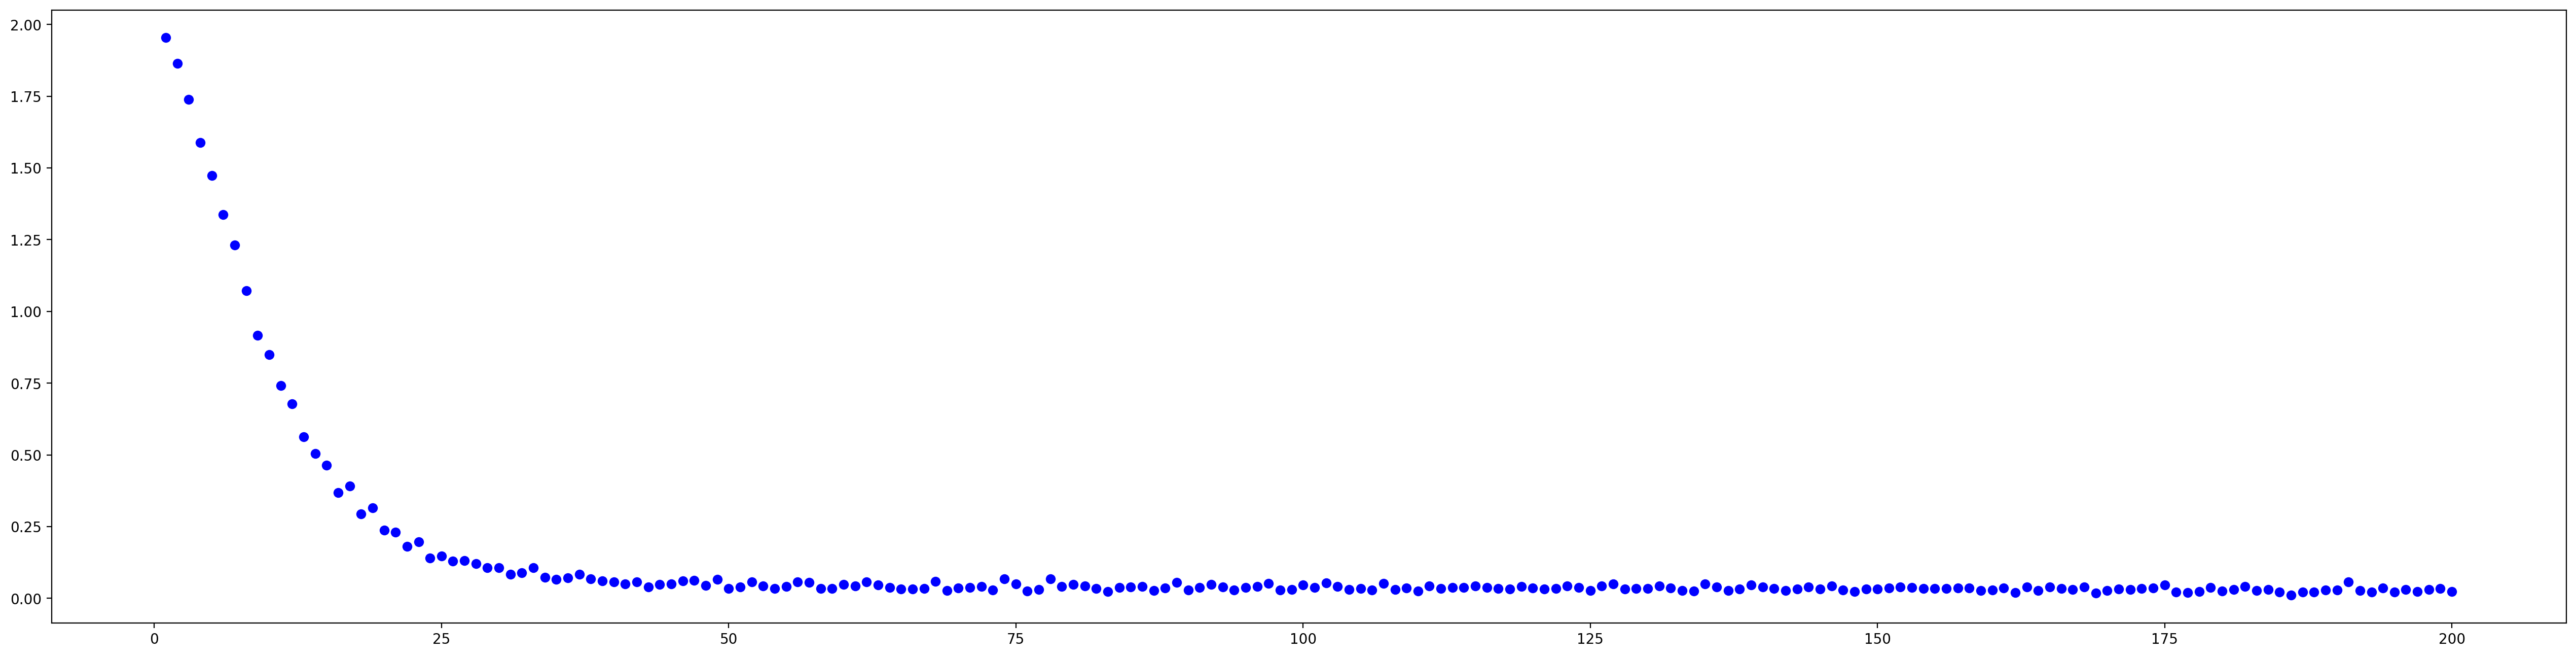

In [ ]:
from matplotlib import pyplot as plt

x = [i+1 for i in range(200)] 
y = training_results_Norm['training_loss']

print(training_results_Norm['validation_accuracy'])
plt.figure(figsize=(32, 8), dpi=200)
plt.scatter(x, y, c ="blue")
 
plt.show()

In [ ]:
PATH = "state_dict_model.pt" 
torch.save(model_norm.state_dict(), PATH)

model = GCN(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load(PATH))

model.eval()
z = model(dataset)
test_z = z[dataset.test_mask]
test_y = dataset.y[dataset.test_mask]

correct = 0
_, label = torch.max(test_z, 1)
correct += (label == test_y).sum().item()
print(test_y.shape, "\t", correct)
test_acc = 100 * (correct / len(test_y))
print(test_acc)

torch.Size([1000]) 	 817
81.69999999999999


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


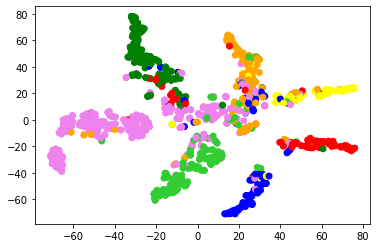

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

colors = []
for i in range(len(test_z)):
  if test_y[i]==0:
    colors.append("orange");
  elif test_y[i]==1:
    colors.append("red");
  elif test_y[i]==2:
    colors.append("green");
  elif test_y[i]==3:
    colors.append("violet");
  elif test_y[i]==4:
    colors.append("limegreen");
  elif test_y[i]==5:
    colors.append("blue");
  elif test_y[i]==6:
    colors.append("yellow");

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_results = tsne.fit_transform(test_z.detach().numpy())

plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c= colors)

In [ ]:
datasets2 = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')
dataset2 = datasets2[0]

criterion = nn.CrossEntropyLoss()
epochs = 200
learning_rate = 0.01
input_dim = dataset2.num_node_features
hidden_dim = 16
output_dim = 6

model_norm2 = GCN(input_dim, hidden_dim, output_dim)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

# model_norm2.apply(init_weights)
optimizer = torch.optim.Adam(model_norm2.parameters(), lr=learning_rate, weight_decay = 5e-4)
training_results_Norm=train(model_norm2, criterion, dataset2, optimizer, epochs)

Processing...
Done!


<class 'torch.Tensor'>
0 	 1.8055390119552612
<class 'torch.Tensor'>
1 	 1.6417250633239746
<class 'torch.Tensor'>
2 	 1.4267045259475708
<class 'torch.Tensor'>
3 	 1.2205156087875366
<class 'torch.Tensor'>
4 	 1.0190151929855347
<class 'torch.Tensor'>
5 	 0.8746297359466553
<class 'torch.Tensor'>
6 	 0.7176886796951294
<class 'torch.Tensor'>
7 	 0.598423957824707
<class 'torch.Tensor'>
8 	 0.48348838090896606
<class 'torch.Tensor'>
9 	 0.4610312283039093
<class 'torch.Tensor'>
10 	 0.3964490294456482
<class 'torch.Tensor'>
11 	 0.3197890818119049
<class 'torch.Tensor'>
12 	 0.28855225443840027
<class 'torch.Tensor'>
13 	 0.25510403513908386
<class 'torch.Tensor'>
14 	 0.2396310716867447
<class 'torch.Tensor'>
15 	 0.18175376951694489
<class 'torch.Tensor'>
16 	 0.16299548745155334
<class 'torch.Tensor'>
17 	 0.14816194772720337
<class 'torch.Tensor'>
18 	 0.13792355358600616
<class 'torch.Tensor'>
19 	 0.1153775155544281
<class 'torch.Tensor'>
20 	 0.10910764336585999
<class 'torch.Te

[65.4]


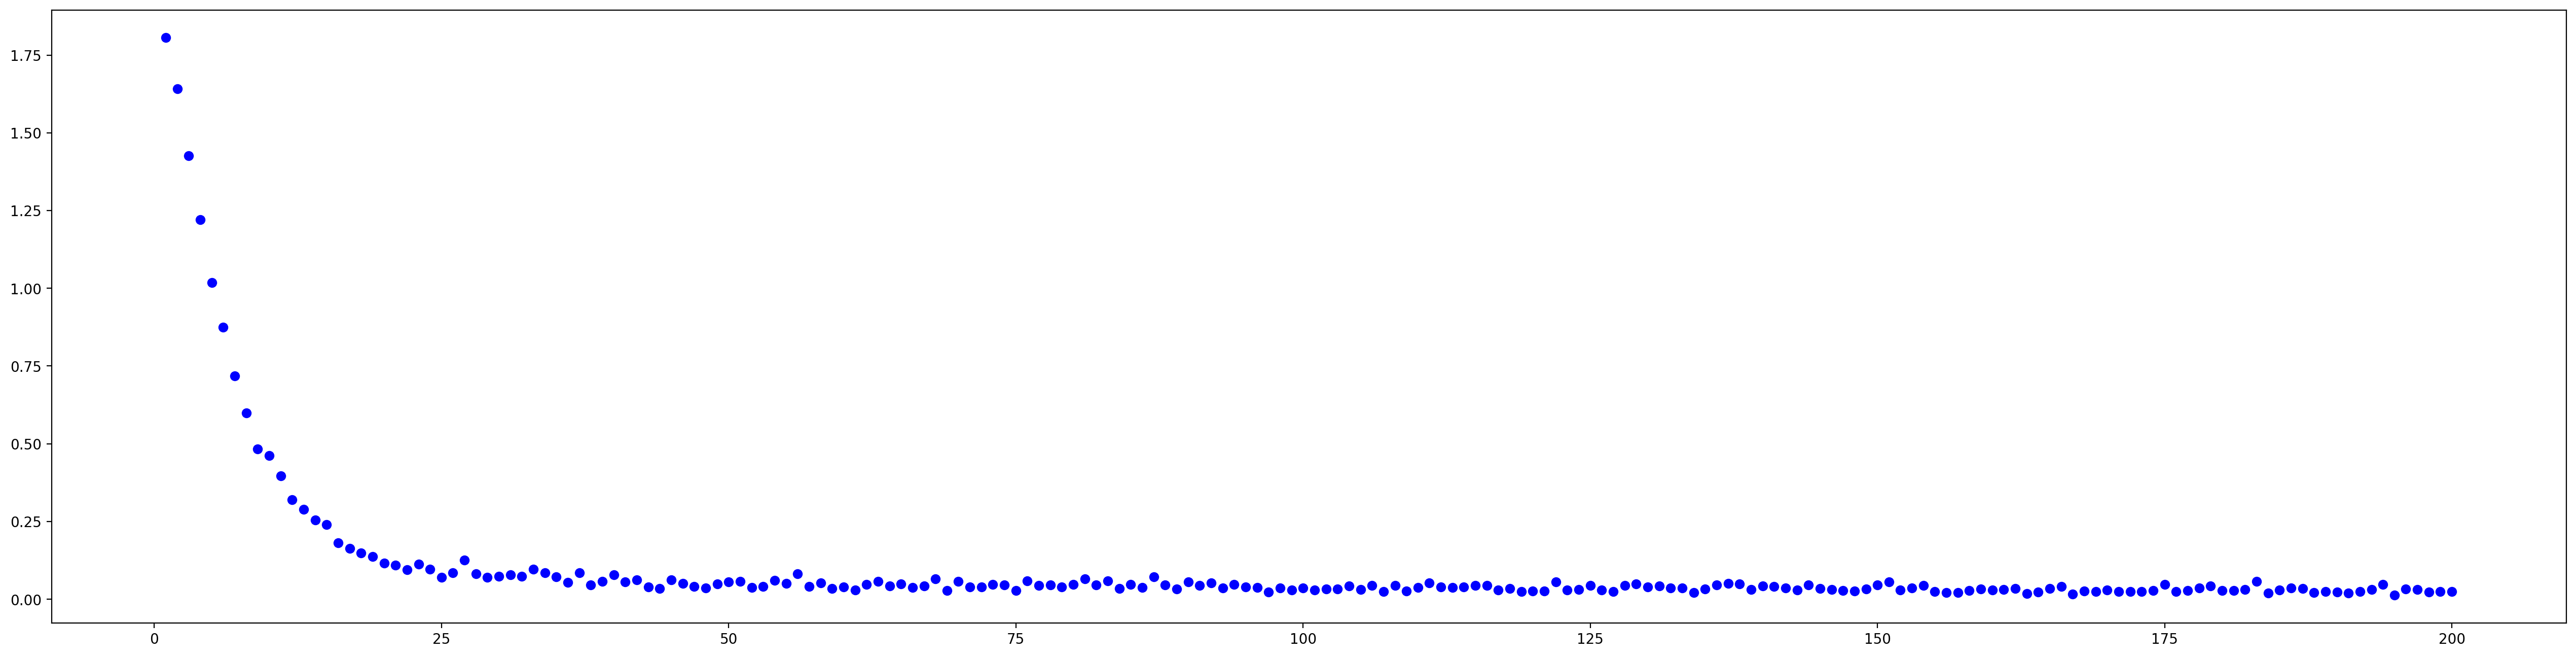

In [ ]:
from matplotlib import pyplot as plt

x = [i+1 for i in range(200)] 
y = training_results_Norm['training_loss']

print(training_results_Norm['validation_accuracy'])
plt.figure(figsize=(32, 8), dpi=200)
plt.scatter(x, y, c ="blue")
 
plt.show()

torch.Size([1000]) 	 658
65.8


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


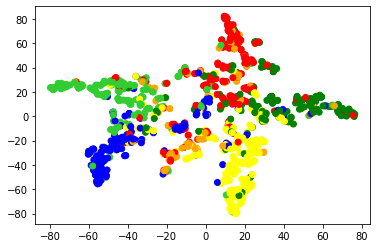

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

PATH = "state_dict_model2.pt" 
torch.save(model_norm2.state_dict(), PATH)

model2 = GCN(input_dim, hidden_dim, output_dim)
# model2.apply(init_weights)
model2.load_state_dict(torch.load(PATH))

model2.eval()
z = model2(dataset2)
test_z = z[dataset2.test_mask]
test_y = dataset2.y[dataset2.test_mask]

correct = 0
_, label = torch.max(test_z, 1)
correct += (label == test_y).sum().item()
print(test_y.shape, "\t", correct)
test_acc = 100 * (correct / len(test_y))
print(test_acc)

colors = []
for i in range(len(test_z)):
  if test_y[i]==0:
    colors.append("orange");
  elif test_y[i]==1:
    colors.append("red");
  elif test_y[i]==2:
    colors.append("green");
  elif test_y[i]==3:
    colors.append("yellow");
  elif test_y[i]==4:
    colors.append("limegreen");
  elif test_y[i]==5:
    colors.append("blue");

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_results = tsne.fit_transform(test_z.detach().numpy())

plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c= colors)

In [ ]:
datasets3 = Planetoid(root='/tmp/PubMed', name='PubMed')
dataset3 = datasets3[0]

criterion = nn.CrossEntropyLoss()
epochs = 100
learning_rate = 0.01
input_dim = dataset3.num_node_features
hidden_dim = 16
output_dim = 3

model_norm3 = GCN(input_dim, hidden_dim, output_dim)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

# model_norm3.apply(init_weights)
optimizer = torch.optim.Adam(model_norm3.parameters(), lr=learning_rate, weight_decay = 5e-4)
training_results_Norm=train(model_norm3, criterion, dataset3, optimizer, epochs)

Processing...
Done!


<class 'torch.Tensor'>
0 	 1.0987961292266846
<class 'torch.Tensor'>
1 	 1.0823441743850708
<class 'torch.Tensor'>
2 	 1.0700840950012207
<class 'torch.Tensor'>
3 	 1.0501267910003662
<class 'torch.Tensor'>
4 	 1.0372848510742188
<class 'torch.Tensor'>
5 	 1.0246226787567139
<class 'torch.Tensor'>
6 	 0.9990355968475342
<class 'torch.Tensor'>
7 	 0.9726250767707825
<class 'torch.Tensor'>
8 	 0.9537271857261658
<class 'torch.Tensor'>
9 	 0.9347097873687744
<class 'torch.Tensor'>
10 	 0.923429548740387
<class 'torch.Tensor'>
11 	 0.8815650939941406
<class 'torch.Tensor'>
12 	 0.8698750138282776
<class 'torch.Tensor'>
13 	 0.8506208658218384
<class 'torch.Tensor'>
14 	 0.8135398030281067
<class 'torch.Tensor'>
15 	 0.8014686703681946
<class 'torch.Tensor'>
16 	 0.7825511693954468
<class 'torch.Tensor'>
17 	 0.7893010973930359
<class 'torch.Tensor'>
18 	 0.7284722924232483
<class 'torch.Tensor'>
19 	 0.715747594833374
<class 'torch.Tensor'>
20 	 0.7018991112709045
<class 'torch.Tensor'>
21

In [ ]:
from matplotlib import pyplot as plt

x = [i+1 for i in range(100)] 
y = training_results_Norm['training_loss']

print(training_results_Norm['validation_accuracy'])
plt.figure(figsize=(32, 8), dpi=200)
plt.scatter(x, y, c ="blue")
 
plt.show()

NameError: ignored

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

PATH = "state_dict_model3.pt" 
torch.save(model_norm3.state_dict(), PATH)

model3 = GCN(input_dim, hidden_dim, output_dim)
model3.apply(init_weights)
model3.load_state_dict(torch.load(PATH))

model3.eval()
z = model3(dataset3)
test_z = z[dataset3.test_mask]
test_y = dataset3.y[dataset3.test_mask]

correct = 0
_, label = torch.max(test_z, 1)
correct += (label == test_y).sum().item()
print(test_y.shape, "\t", correct)
test_acc = 100 * (correct / len(test_y))
print(test_acc)

colors = []
for i in range(len(test_z)):
  if test_y[i]==0:
    colors.append("red");
  elif test_y[i]==1:
    colors.append("green");
  elif test_y[i]==2:
    colors.append("blue");

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_results = tsne.fit_transform(test_z.detach().numpy())

plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c= colors)

In [ ]:
import torch
import torch.nn as nn

m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()
print(input)
print(target)
print(output)